In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [54]:
#importing dataset
df = pd.read_csv('GOOG.csv')

In [3]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
5,2004-08-26,52.279045,53.773445,52.134586,53.753517,53.753517,7128600
6,2004-08-27,53.848164,54.107193,52.647663,52.876804,52.876804,6241200
7,2004-08-30,52.443428,52.548038,50.814533,50.814533,50.814533,5221400
8,2004-08-31,50.958992,51.661362,50.889256,50.993862,50.993862,4941200
9,2004-09-01,51.158245,51.292744,49.648903,49.937820,49.937820,9181600


In [4]:
cols = list(df)[1:6]

In [5]:
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [6]:
datelist = list(df['Date'])


In [7]:
#datelist

In [8]:
datelist = [dt.datetime.strptime(date, '%Y-%m-%d').date()  for date in datelist]

In [9]:
#datelist

In [10]:
training_set=df.iloc[:,1:6].values

In [11]:
training_set

array([[  49.813286,   51.835709,   47.800831,   49.982655,   49.982655],
       [  50.316402,   54.336334,   50.062355,   53.95277 ,   53.95277 ],
       [  55.168217,   56.528118,   54.321388,   54.495735,   54.495735],
       ...,
       [1523.130005, 1535.329956, 1498.      , 1513.640015, 1513.640015],
       [1500.      , 1518.689941, 1486.310059, 1518.      , 1518.      ],
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049]])

In [12]:
print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (4006, 5).


In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.27195197],
       [-1.27058974],
       [-1.25745309],
       ...,
       [ 2.71716347],
       [ 2.65453724],
       [ 2.713075  ]])

In [14]:
len(training_set_scaled)

4006

In [15]:
training_set_scaled

array([[-1.27195197, -1.26786213, -1.2745642 , -1.27028724, -1.27028724],
       [-1.27058974, -1.26115415, -1.26838862, -1.2595499 , -1.2595499 ],
       [-1.25745309, -1.25527464, -1.25675839, -1.25808143, -1.25808143],
       ...,
       [ 2.71716347,  2.71164316,  2.68552176,  2.68823148,  2.68823148],
       [ 2.65453724,  2.66700596,  2.65359982,  2.70002324,  2.70002324],
       [ 2.713075  ,  2.67974794,  2.68666878,  2.69339725,  2.69339725]])

# 30 days and 90 days

In [16]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 30   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:training_set.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3887, 90, 4).
y_train shape == (3887, 1).


In [17]:
#training_set_scaled[i - n_past:i, 0:training_set.shape[1] - 1]

In [18]:
training_set_scaled[i + n_future - 1:i + n_future, 0]

array([2.713075])

# creating model

In [19]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [20]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, training_set.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [25]:
#history = model.fit(X_train, y_train, shuffle=True, epochs=30, validation_split=0.2, verbose=1, batch_size=256)

In [21]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=112)

Epoch 1/30
28/28 [==============================] - 8s 93ms/step - loss: 0.1071 - val_loss: 0.5476

Epoch 00001: val_loss improved from inf to 0.54756, saving model to weights.h5
Epoch 2/30
28/28 [==============================] - 1s 27ms/step - loss: 0.0246 - val_loss: 0.5685

Epoch 00002: val_loss did not improve from 0.54756
Epoch 3/30
28/28 [==============================] - 1s 27ms/step - loss: 0.0246 - val_loss: 0.3341

Epoch 00003: val_loss improved from 0.54756 to 0.33410, saving model to weights.h5
Epoch 4/30
28/28 [==============================] - 1s 27ms/step - loss: 0.0208 - val_loss: 0.2942

Epoch 00004: val_loss improved from 0.33410 to 0.29419, saving model to weights.h5
Epoch 5/30
28/28 [==============================] - 1s 28ms/step - loss: 0.0209 - val_loss: 0.3605

Epoch 00005: val_loss did not improve from 0.29419
Epoch 6/30
28/28 [==============================] - 1s 27ms/step - loss: 0.0208 - val_loss: 0.2042

Epoch 00006: val_loss improved from 0.29419 to 0.2041

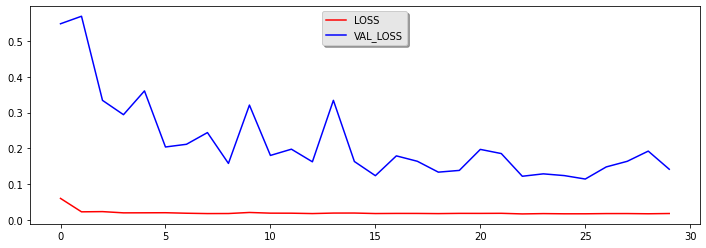

In [22]:
#plotting the graphs for loss and validation loss
fig, ax = plt.subplots(figsize=(12,4))

plt.plot(history.history['loss'], color='red', label='LOSS')
plt.plot(history.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

In [23]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [24]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [26]:
#len(predictions_train)

In [28]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))

In [31]:
# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)
PREDICTIONS_FUTURE.index = PREDICTIONS_FUTURE.index.to_series().apply(datetime_to_timestamp)

In [32]:
PREDICTIONS_FUTURE

,Open
2020-07-17,1120.538574
2020-07-18,1121.744019
2020-07-19,1124.628418
2020-07-20,1122.682983
2020-07-21,1131.996216
2020-07-22,1137.469971
2020-07-23,1139.250610
2020-07-24,1138.559937
2020-07-25,1140.923218
2020-07-26,1142.557129


TypeError: slice indices must be integers or None or have an __index__ method

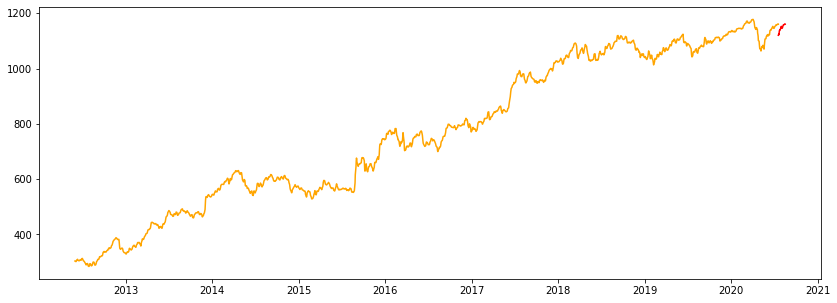

In [35]:
# Set plot size 
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, training_set[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices',family='sans-serif', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

# Hyperparameter tuning with different splits and batch sizes

# split size 70-30

In [39]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs2')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=112)

Epoch 1/30
25/25 [==============================] - 2s 69ms/step - loss: 0.0121 - val_loss: 0.1512

Epoch 00001: val_loss improved from inf to 0.15116, saving model to weights.h5
Epoch 2/30
25/25 [==============================] - 1s 29ms/step - loss: 0.0122 - val_loss: 0.1541

Epoch 00002: val_loss did not improve from 0.15116
Epoch 3/30
25/25 [==============================] - 1s 29ms/step - loss: 0.0130 - val_loss: 0.1530

Epoch 00003: val_loss did not improve from 0.15116
Epoch 4/30
25/25 [==============================] - 1s 30ms/step - loss: 0.0128 - val_loss: 0.1497

Epoch 00004: val_loss improved from 0.15116 to 0.14974, saving model to weights.h5
Epoch 5/30
25/25 [==============================] - 1s 29ms/step - loss: 0.0120 - val_loss: 0.1672

Epoch 00005: val_loss did not improve from 0.14974
Epoch 6/30
25/25 [==============================] - 1s 29ms/step - loss: 0.0127 - val_loss: 0.1897

Epoch 00006: val_loss did not improve from 0.14974
Epoch 7/30
25/25 [================

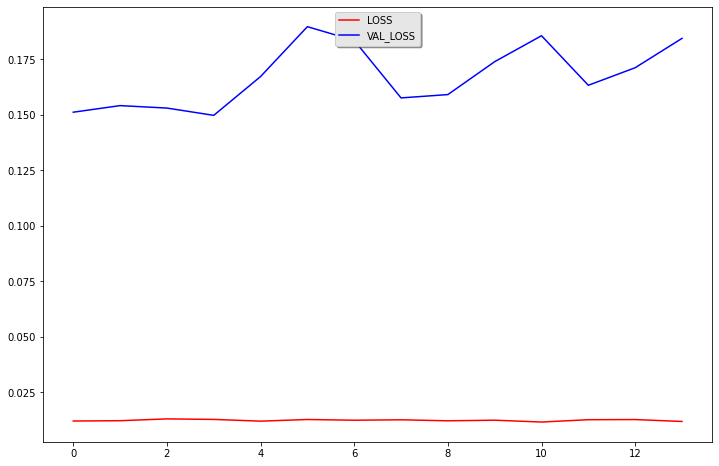

In [41]:
#plotting the graphs for loss and validation loss
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(history.history['loss'], color='red', label='LOSS')
plt.plot(history.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

# split size 60-40

In [42]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs2')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.4, verbose=1, batch_size=112)

Epoch 1/100
21/21 [==============================] - 2s 81ms/step - loss: 0.0089 - val_loss: 0.1624

Epoch 00001: val_loss improved from inf to 0.16242, saving model to weights.h5
Epoch 2/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0087 - val_loss: 0.1689

Epoch 00002: val_loss did not improve from 0.16242
Epoch 3/100
21/21 [==============================] - 1s 34ms/step - loss: 0.0086 - val_loss: 0.1805

Epoch 00003: val_loss did not improve from 0.16242
Epoch 4/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0087 - val_loss: 0.1795

Epoch 00004: val_loss did not improve from 0.16242
Epoch 5/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0083 - val_loss: 0.1827

Epoch 00005: val_loss did not improve from 0.16242
Epoch 6/100
21/21 [==============================] - 1s 33ms/step - loss: 0.0088 - val_loss: 0.1845

Epoch 00006: val_loss did not improve from 0.16242
Epoch 7/100
21/21 [==============================] - 1s 33ms

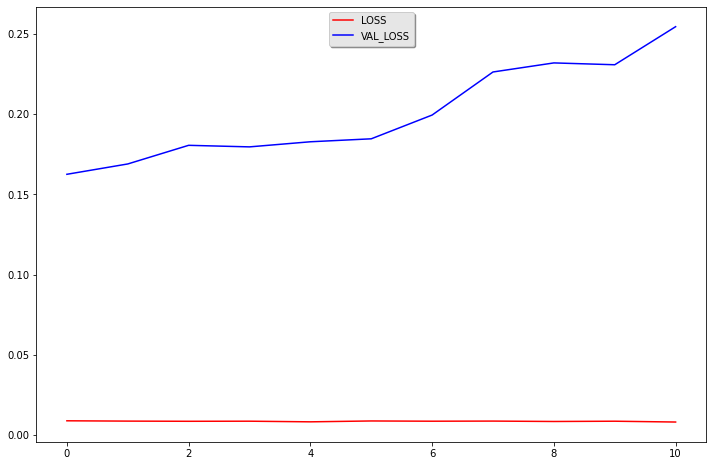

In [43]:
#plotting the graphs for loss and validation loss
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(history.history['loss'], color='red', label='LOSS')
plt.plot(history.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

# split size 90-10

In [44]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs2')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.1, verbose=1, batch_size=112)

Epoch 1/100
32/32 [==============================] - 2s 57ms/step - loss: 0.0395 - val_loss: 0.1866

Epoch 00001: val_loss improved from inf to 0.18655, saving model to weights.h5
Epoch 2/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0360 - val_loss: 0.2592

Epoch 00002: val_loss did not improve from 0.18655
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0373 - val_loss: 0.1979

Epoch 00003: val_loss did not improve from 0.18655
Epoch 4/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0341 - val_loss: 0.2239

Epoch 00004: val_loss did not improve from 0.18655
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0353 - val_loss: 0.2001

Epoch 00005: val_loss did not improve from 0.18655
Epoch 6/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0326 - val_loss: 0.2174

Epoch 00006: val_loss did not improve from 0.18655
Epoch 7/100
32/32 [==============================] - 1s 25ms

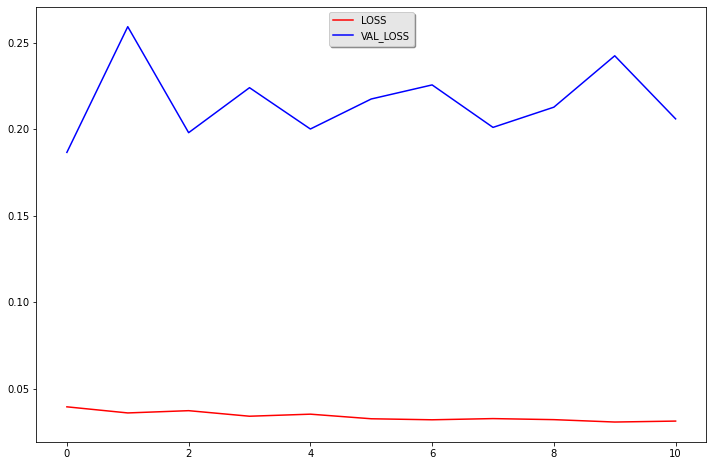

In [45]:
#plotting the graphs for loss and validation loss
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(history.history['loss'], color='red', label='LOSS')
plt.plot(history.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

# batch size 256

In [46]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs2')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.1, verbose=1, batch_size=256)

Epoch 1/100
14/14 [==============================] - 1s 105ms/step - loss: 0.0329 - val_loss: 0.1820

Epoch 00001: val_loss improved from inf to 0.18198, saving model to weights.h5
Epoch 2/100
14/14 [==============================] - 0s 30ms/step - loss: 0.0302 - val_loss: 0.2120

Epoch 00002: val_loss did not improve from 0.18198
Epoch 3/100
14/14 [==============================] - 0s 30ms/step - loss: 0.0295 - val_loss: 0.2137

Epoch 00003: val_loss did not improve from 0.18198
Epoch 4/100
14/14 [==============================] - 0s 31ms/step - loss: 0.0299 - val_loss: 0.2161

Epoch 00004: val_loss did not improve from 0.18198
Epoch 5/100
14/14 [==============================] - 0s 30ms/step - loss: 0.0294 - val_loss: 0.1941

Epoch 00005: val_loss did not improve from 0.18198
Epoch 6/100
14/14 [==============================] - 0s 30ms/step - loss: 0.0325 - val_loss: 0.2062

Epoch 00006: val_loss did not improve from 0.18198
Epoch 7/100
14/14 [==============================] - 0s 31m

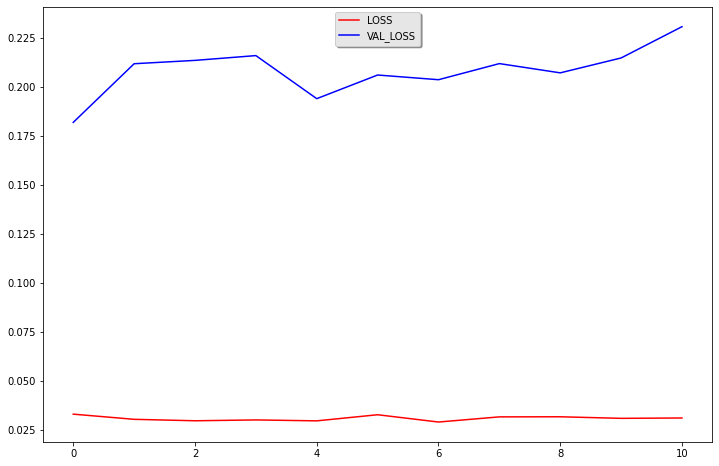

In [47]:
#plotting the graphs for loss and validation loss
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(history.history['loss'], color='red', label='LOSS')
plt.plot(history.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

#  split size 90-10 and batch size 12

In [48]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs2')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.1, verbose=1, batch_size=12)

Epoch 1/100
292/292 [==============================] - 8s 26ms/step - loss: 0.0305 - val_loss: 0.1963

Epoch 00001: val_loss improved from inf to 0.19631, saving model to weights.h5
Epoch 2/100
292/292 [==============================] - 7s 23ms/step - loss: 0.0285 - val_loss: 0.2493

Epoch 00002: val_loss did not improve from 0.19631
Epoch 3/100
292/292 [==============================] - 7s 23ms/step - loss: 0.0302 - val_loss: 0.2366

Epoch 00003: val_loss did not improve from 0.19631
Epoch 4/100
292/292 [==============================] - 7s 23ms/step - loss: 0.0286 - val_loss: 0.1892

Epoch 00004: val_loss improved from 0.19631 to 0.18923, saving model to weights.h5
Epoch 5/100
292/292 [==============================] - 7s 23ms/step - loss: 0.0321 - val_loss: 0.1694

Epoch 00005: val_loss improved from 0.18923 to 0.16942, saving model to weights.h5
Epoch 6/100
292/292 [==============================] - 7s 23ms/step - loss: 0.0298 - val_loss: 0.2283

Epoch 00006: val_loss did not impro

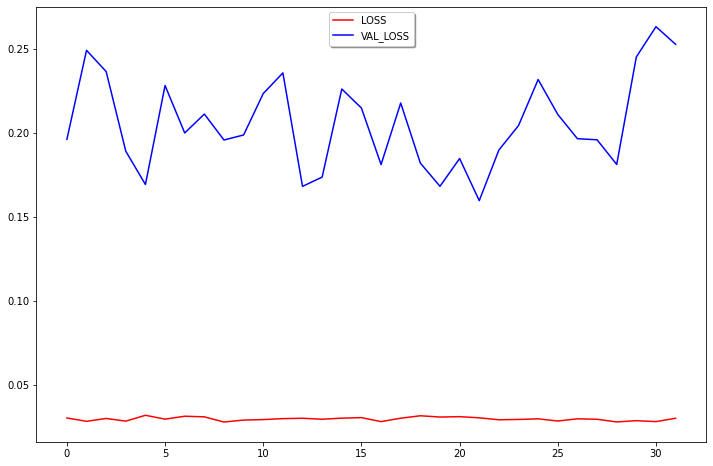

In [53]:
#plotting the graphs for loss and validation loss
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(history.history['loss'], color='red', label='LOSS')
plt.plot(history.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
#frame.set_facecolor('0.90')